<a href="https://colab.research.google.com/github/quinn-hoang/Coursework-portfolio/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time series data analysis

1.   ARIMA
2.   ARCH/GARCH MODELS



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import  seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00


In [5]:
import yfinance as yf

In [31]:
import datetime
start_date =datetime.datetime(2017,1,1)
end_date =datetime.datetime(2024,7,5)

In [7]:
Ticker = ['^GSPC','JPM']

In [32]:
data = yf.download(Ticker,start=start_date,end=end_date)['Close']
data

[*********************100%%**********************]  2 of 2 completed


Ticker,JPM,^GSPC
Date,,
2017-01-03,87.230003,2257.830078
2017-01-04,86.910004,2270.750000
2017-01-05,86.110001,2269.000000
2017-01-06,86.120003,2276.979980
2017-01-09,86.180000,2268.899902
...,...,...
2024-06-27,199.169998,5482.870117
2024-06-28,202.259995,5460.479980
2024-07-01,205.449997,5475.089844


In [33]:
JPM=data.JPM
JPM.index=pd.DatetimeIndex(JPM.index).to_period(freq='B')


In [34]:
returns= JPM.pct_change()
returns = returns.iloc[1:]

In [35]:
#perform augmented Dickey-fuller test to  check if returns are stationary
pvalue=adfuller(returns)[1]
if pvalue<0.05:
    print('stationary: d=1')
else:
    print('non-stationary: d >1')

stationary: d=1


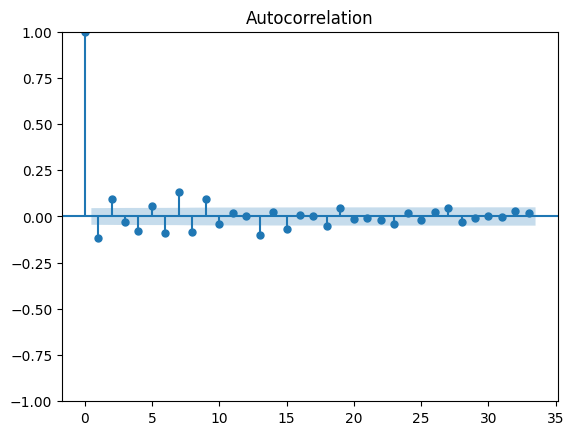

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
plot_acf(returns)
plt.show()

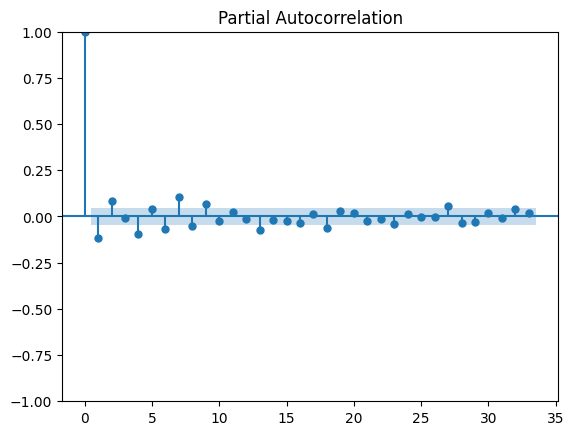

In [37]:
plot_pacf(returns)
plt.show()

In [38]:
model = ARIMA(JPM,order=(1,1,1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    JPM   No. Observations:                 1887
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4052.798
Date:                Sat, 13 Jul 2024   AIC                           8111.595
Time:                        13:54:21   BIC                           8128.222
Sample:                    01-03-2017   HQIC                          8117.718
                         - 07-03-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4444      0.120     -3.702      0.000      -0.680      -0.209
ma.L1          0.3773      0.122      3.086      0.002       0.138       0.617
sigma2         4.3055      0.067     64.172      0.000       4.174       4.437
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):              4486.02
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):               3.01   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
#find the optimize order of p and q
maximum_order =10
arima_summary_dict = {}
for p in range(11):
    for q in range(11):
        if p+q<= maximum_order:

            model =ARIMA(JPM,order =(p,1,q)).fit()
            if p>0:
                ar_last_pvalue=round(model.pvalues[f'ar.L{p}'],3)
            else:
                ar_last_pvalue =0

            if q>0:
                ma_pvalue = round(model.pvalues[f'ma.L{q}'],3)
            else:
                ma_pvalue =0

            arima_summary_dict[f'{p}-{q}']=[round(model.aic,2),ar_last_pvalue,ma_pvalue]

In [40]:
# Check AIC and p-values to find the best model

alpha = 0.05

lowest_AIC = 99999999999

for order in arima_summary_dict.keys():
    aic = arima_summary_dict[order][0]
    if aic < lowest_AIC:

        if (arima_summary_dict[order][1] < alpha) & (arima_summary_dict[order][2] < alpha):
            lowest_AIC = aic
            best_order = order

print(best_order)
print(arima_summary_dict[best_order])

3-6
[8068.66, 0.0, 0.002]


In [41]:
best_p =int(best_order.split('-')[0])
best_q =int(best_order.split('-')[1])
best_model =ARIMA(JPM,order =(best_p,1,best_q)).fit()
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    JPM   No. Observations:                 1887
Model:                 ARIMA(3, 1, 6)   Log Likelihood               -4024.332
Date:                Sat, 13 Jul 2024   AIC                           8068.664
Time:                        13:57:48   BIC                           8124.086
Sample:                    01-03-2017   HQIC                          8089.074
                         - 07-03-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0984      0.119    -17.567      0.000      -2.333      -1.864
ar.L2         -1.7313      0.195     -8.883      0.000      -2.113      -1.349
ar.L3         -0.5010      0.106     -4.718      0.000      -0.709      -0.293
ma.L1          2.0689      0.119     17.399      0.000       1.836       2.302
ma.L2          1.7315      0.191      9.066      0.000       1.357       2.106
ma.L3          0.5769      0.116      4.959      0.000       0.349       0.805
ma.L4          0.0430      0.053      0.810      0.418      -0.061       0.147
ma.L5         -0.0452      0.047     -0.954      0.340      -0.138       0.048
ma.L6         -0.0721      0.023     -3.115      0.002      -0.117      -0.027
sigma2         4.1768      0.076     54.816      0.000       4.027       4.326
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3100.65
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**FORECASTS**

In [49]:
#get tomorrow's price
tom_price=best_model.forecast(steps=1)[0]
tom_price

208.44082030333618

In [43]:
import datetime
start_date =datetime.datetime(2024,6,25)
end_date =datetime.datetime(2024,7,12)

In [44]:
Ticker = ['^GSPC','JPM']

In [26]:
df = yf.download(Ticker,start=start_date,end=end_date)['Close']
df

[*********************100%%**********************]  2 of 2 completed


Ticker,JPM,^GSPC
Date,,
2024-06-25,198.070007,5469.299805
2024-06-26,197.429993,5477.899902
2024-06-27,199.169998,5482.870117
2024-06-28,202.259995,5460.479980
2024-07-01,205.449997,5475.089844
2024-07-02,208.830002,5509.009766
2024-07-03,208.690002,5537.020020
2024-07-05,204.789993,5567.189941
2024-07-08,205.169998,5572.850098


In [45]:
todays_price = JPM.iloc[-1]
print(f"Today's price: ${round(todays_price, 2)}")

if tom_price > todays_price:
    print('\nPrice is going to go up! Buy!')
else:
    print('\nPrice is going to go down! Sell!')


Today's price: $208.69

Price is going to go down! Sell!
